# New York AirBnB Data
Using the NewYork data - useful facts about the data:

Business Questions (Business Understanding)
<b><li>What are the most common type of  properties in NewYork available for renting?What are the availabilities of the properties throughout the year?What property types have the highest availabilty?</li></b> 

<b><li>What is the average pricing of the properties available for renting?Are there any seasonal spiking in the prices of the properties?</li></b> 

<b><li>What streets have the highest and lowest property prices? 
Where to Invest a Property in NewYork to get maximum returns from Airbnb?</li></b> 

<b><li>How well can we predict the prices of the properties?What price can you get to rent your home,what factors determine the price of your home?</li></b> 

First, let's read in the necessary libraries and datasets.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [14]:
listings = pd.read_csv('listings.csv')
calendar = pd.read_csv('calendar.csv')

Little data wrangling and cleaning here, to prepare the data for analysis 

In [15]:
#droping columns which are not usefull in  analysing the respective questions.
listings = listings.drop(['transit', 'neighborhood_overview', 'listing_url', 'summary', 'space', 'description', 
                          'access', 'interaction', 'house_rules', 'thumbnail_url','medium_url','picture_url', 
                          'xl_picture_url', 'host_url', 'host_name', 'host_about', 'host_thumbnail_url', 'host_verifications',
                          'calendar_updated'], axis = 1)

In [16]:
#removing columns which has only one value as that column would be not usefull for analysis 
for col in listings:
    if listings[col].value_counts().count() <= 1:
        listings = listings.drop(col, axis = 1)

In [17]:
#dropping the columns which have 60% of its values missing
for col in listings:
        percentage = listings[col].isna().sum() / listings.shape[0] * 100
        if percentage > 60:
            listings = listings.drop(col, axis = 1)

In [18]:
#Replacing Nan values with 0
listings.fillna(0, inplace = True)
calendar.fillna(0, inplace = True)

In [19]:
listings.price.dtype

dtype('O')

In [20]:
calendar.price.dtype

dtype('O')

In [21]:
#converting price into float
listings['price'] = listings['price'].apply(lambda x: float(str(x).replace('$', '').replace(',', '')))
calendar['price'] = calendar['price'].apply(lambda x: float(str(x).replace('$', '').replace(',', '')))

In [22]:
calendar['date'].head()

0    2019-09-13
1    2019-09-13
2    2019-09-14
3    2019-09-15
4    2019-09-16
Name: date, dtype: object

In [23]:
#adding a new column Year-Month to do the monthly analysis of the data
calendar['Year-Month'] = calendar['date'].apply(lambda x:(str(x).replace(x, x[0:7])))
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,Year-Month
0,9668,2019-09-13,f,51.0,$51.00,3.0,365.0,2019-09
1,26969,2019-09-13,f,350.0,$350.00,3.0,33.0,2019-09
2,26969,2019-09-14,f,350.0,$350.00,3.0,33.0,2019-09
3,26969,2019-09-15,f,350.0,$350.00,3.0,33.0,2019-09
4,26969,2019-09-16,f,350.0,$350.00,3.0,33.0,2019-09


In [24]:
calendar.available.dtype

dtype('O')

In [25]:
#converting the column "available" into boolean for performing operations
calendar.available.replace('f', False, inplace = True)
calendar.available.replace('t', True, inplace = True)
calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,Year-Month
0,9668,2019-09-13,False,51.0,$51.00,3.0,365.0,2019-09
1,26969,2019-09-13,False,350.0,$350.00,3.0,33.0,2019-09
2,26969,2019-09-14,False,350.0,$350.00,3.0,33.0,2019-09
3,26969,2019-09-15,False,350.0,$350.00,3.0,33.0,2019-09
4,26969,2019-09-16,False,350.0,$350.00,3.0,33.0,2019-09


<b>1) What are the most common type of properties in NewYork available for renting?What are the availabilities of the properties throughout the year?What property types have the highest availabilty?</b>

In [35]:
#grouping property types by their id count and sorting them according in descing order
common_properties=listings.groupby(['property_type']).count()['id'].reset_index().sort_values(ascending=False, by='id').head(9)
common_properties

,property_type,id
1,Apartment,38144
22,House,3944
33,Townhouse,1624
13,Condominium,1512
25,Loft,1375
29,Serviced apartment,437
18,Guest suite,382
21,Hotel,219
5,Boutique hotel,214


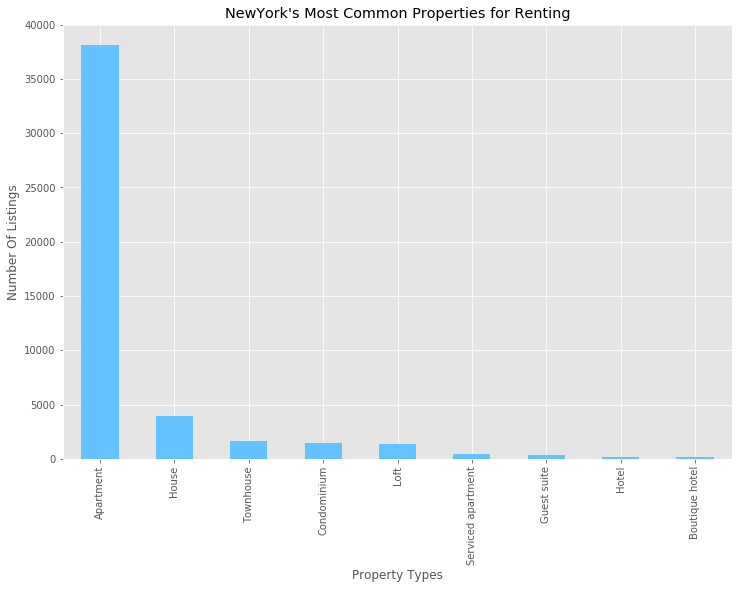

In [49]:
#plotting the data of the table above
plt.style.use('ggplot');

common_properties.plot(kind='bar', 
           x='property_type',
           y='id',
           color = '#66c2ff', 
           figsize =(12,8), 
           title = "NewYork's Most Common Properties for Renting", 
           legend = False);
plt.xlabel('Property Types')
plt.ylabel('Number Of Listings');

It can be concluded that property type also plays an important factor. Not surprisingly, Apartment and houses take up an overwhelming majority of all listings, followed by townhouse and Condominium.